# Creditcard Fraud - Logistic Regression

The goal of this project is to build a straightforward Logistic Regression model for detecting credit card fraud, showcasing how Fully Homomorphic Encryption (FHE) can protect sensitive data during prediction. Because legitimate transactions vastly outnumber fraudulent ones, one key challenge is achieving a model that remains highly sensitive to fraud despite this imbalance.

We will use a publicly available dataset from Kaggle, which contains transactions made by European credit card holders over two days in September 2013. The dataset is highly imbalanced: of 284,807 transactions, only 492 (around 0.172%) are fraudulent. Most input variables are numeric features resulting from a PCA transformation, performed to maintain confidentiality. The only features not transformed by PCA are Time—which records the seconds elapsed between each transaction and the first transaction—and Amount, indicating the transaction value.

The target variable, Class, denotes whether a transaction is fraudulent (1) or legitimate (0). By integrating FHE into our pipeline, this demo will illustrate how organizations can perform fraud detection inference securely without revealing either sensitive transaction details or model parameters.

## Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn
import numpy as np 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data set

In [2]:
df = pd.read_csv("creditcardfraud/creditcard.csv")
print('Number of rows amd columns',df.shape)

Number of rows amd columns (284807, 31)


In [3]:
# info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
# show statistical properties
df.describe().round()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,...,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
mean,94814.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,88.0,0.0
std,47488.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,250.0,0.0
min,0.0,-56.0,-73.0,-48.0,-6.0,-114.0,-26.0,-44.0,-73.0,-13.0,...,-35.0,-11.0,-45.0,-3.0,-10.0,-3.0,-23.0,-15.0,0.0,0.0
25%,54202.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,...,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,6.0,0.0
50%,84692.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,...,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,22.0,0.0
75%,139320.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,0.0
max,172792.0,2.0,22.0,9.0,17.0,35.0,73.0,121.0,20.0,16.0,...,27.0,11.0,23.0,5.0,8.0,4.0,32.0,34.0,25691.0,1.0


## Normal transactions versus fraud

Non Fraud %  99.83
Fraud %     0.17


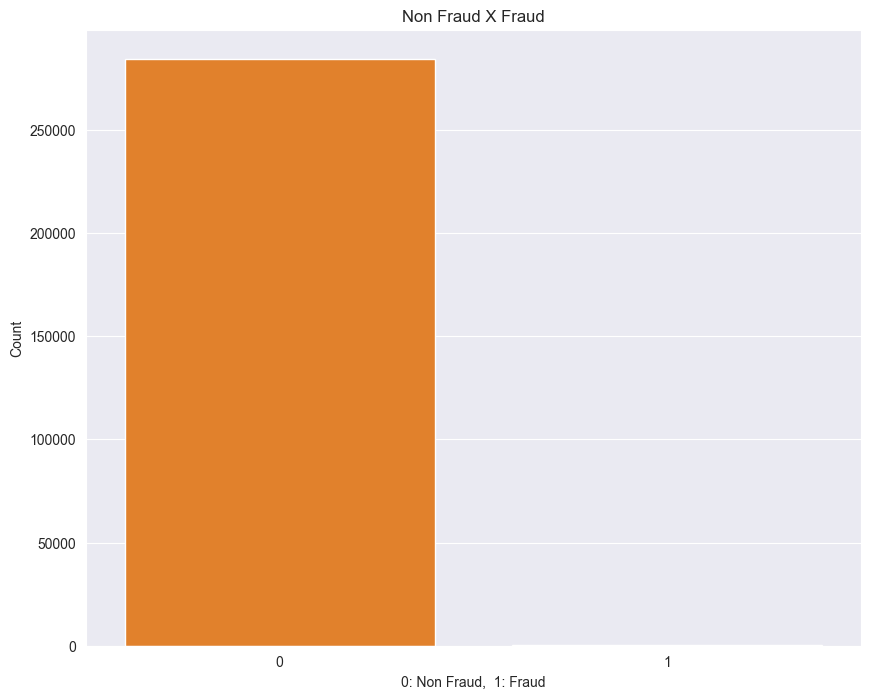

In [6]:
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.barplot(x=df['Class'].value_counts().index,y=df['Class'].value_counts(), palette=["C1", "C8"])
plt.title('Non Fraud X Fraud')
plt.ylabel('Count')
plt.xlabel('0: Non Fraud,  1: Fraud')
print ('Non Fraud % ',round(df['Class'].value_counts()[0]/len(df)*100,2))
print ('Fraud %    ',round(df['Class'].value_counts()[1]/len(df)*100,2));

## Defining features and traget => f(X) = y

In [7]:
feature_names = df.iloc[:, 1:30].columns
target = df.iloc[:1, 30:].columns

data_features = df[feature_names]
data_target = df[target]

In [8]:
feature_names

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [9]:
target

Index(['Class'], dtype='object')

After defining the dataset and separating the input features from the target variable, we used the train_test_split function to divide the data into training and test sets. Specifically, 70% of the data was allocated for training while 30% was set aside for testing. This function relies on randomization, so we used a random seed (np.random.seed) to ensure that each run uses the same data split.

In [10]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, 
                                                    train_size = 0.70, test_size = 0.30, random_state = 1)

# Training the Logistic model

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

# Model Run and check performance: Confusion Matrix

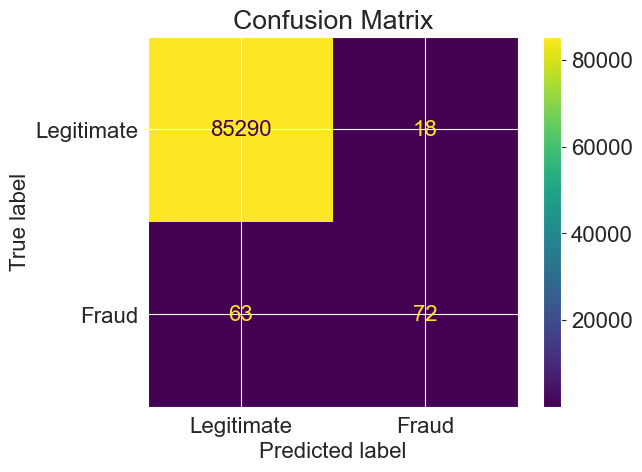

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import  ConfusionMatrixDisplay

def PrintStats(cmat, y_test, pred):
    tpos = cmat[0][0]
    fneg = cmat[1][1]
    fpos = cmat[0][1]
    tneg = cmat[1][0]

def RunModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, pred)
    return matrix, pred


cmat, pred = RunModel(lr, X_train, y_train, X_test, y_test)

# Optionally, provide names for the classes
class_names = ['Legitimate', 'Fraud']
plt.rcParams.update({'font.size': 16})
# Create a ConfusionMatrixDisplay and plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=class_names)
disp.plot(values_format='d')  # 'd' to display numbers as integers
plt.title('Confusion Matrix')
plt.show()

In [13]:
accuracy_score(y_test, pred)

0.9990519995786665

In [14]:
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.80      0.53      0.64       135

    accuracy                           1.00     85443
   macro avg       0.90      0.77      0.82     85443
weighted avg       1.00      1.00      1.00     85443



# Inital results
The confusion matrix for the Logistic Regression model indicates:

- 85,290 transactions were correctly classified as normal
- 18 transactions were incorrectly flagged as fraud (Type I error)
- 63 transactions were mislabeled as normal but were actually fraud (Type II error)
- 72 transactions were correctly identified as fraud

(!) Although the model’s accuracy appears high, it still misclassifies around 4 out of 10 fraudulent transactions. This highlights why accuracy alone is - not a reliable measure for performance on highly imbalanced datasets. Before evaluating any performance metrics, it is essential to apply a technique - to rebalance the data (e.g., undersampling, oversampling) to ensure a more meaningful assessment of the model’s effectiveness.

# Fine Tuning the model
Undersampling and oversampling are common techniques for handling highly imbalanced datasets, where most transactions are legitimate and only a small fraction are fraudulent. By modifying the distribution of the classes, these methods help models become more sensitive to minority classes—like fraud—in credit card transaction data.

- Undersampling reduces the number of majority-class examples (legitimate transactions) to match the minority class. Although it balances the dataset, it also removes valuable information from the majority class.

- Oversampling increases the minority-class examples (fraud). Methods such as random oversampling or SMOTE replicate or synthetically generate additional fraud cases, leading to a more balanced training set and helping the model learn to detect fraudulent transactions more effectively.

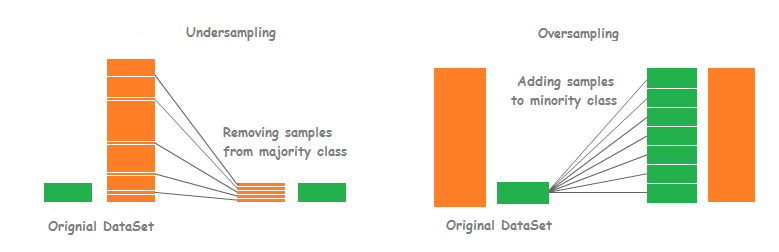

## Applying the undersampling

In [15]:
# The function "len" counts the number of classes = 1 and saves it as an object "fraud_records"
fraud_records = len(df[df.Class == 1])

# Defines the index for fraud and non-fraud in the lines:
fraud_indices = df[df.Class == 1].index
not_fraud_indices = df[df.Class == 0].index

# Randomly collect equal samples of each type:
under_sample_indices = np.random.choice(not_fraud_indices, fraud_records, False)
df_undersampled = df.iloc[np.concatenate([fraud_indices, under_sample_indices]),:]
X_undersampled = df_undersampled.iloc[:,1:30]
Y_undersampled = df_undersampled.Class
X_undersampled_train, X_undersampled_test, Y_undersampled_train, Y_undersampled_test = train_test_split(X_undersampled, Y_undersampled, test_size = 0.30)

## Retrain the Model

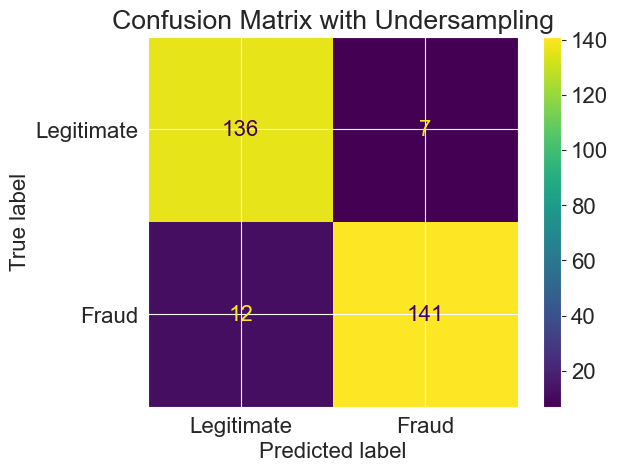

In [16]:
lr_undersampled = LogisticRegression()
cmat, pred = RunModel(lr_undersampled, X_undersampled_train, Y_undersampled_train, X_undersampled_test, Y_undersampled_test)
PrintStats(cmat, Y_undersampled_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=class_names)
disp.plot(values_format='d')  # 'd' to display numbers as integers
plt.title('Confusion Matrix with Undersampling')
plt.show()

In [17]:
accuracy_score(Y_undersampled_test, pred)

0.9358108108108109

In [18]:
print (classification_report(Y_undersampled_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       143
           1       0.95      0.92      0.94       153

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



Although overall accuracy has decreased, sensitivity has substantially improved. From the confusion matrix, it is clear that the model now correctly identifies a larger proportion of fraudulent transactions. However, this improvement often comes at the cost of flagging more legitimate transactions as fraudulent.

## Using the new classifier for the original data test

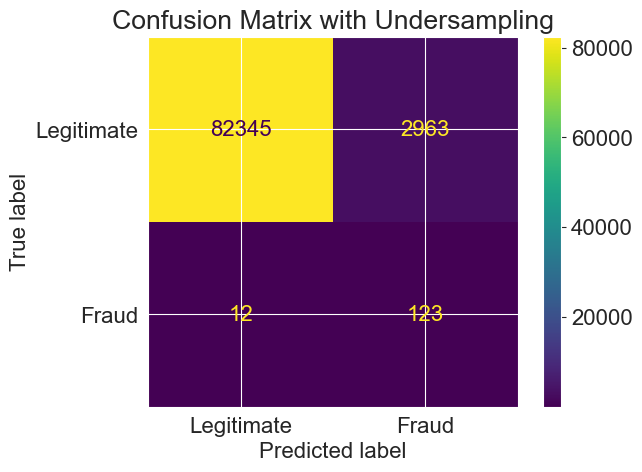

In [19]:
lr_undersampled = LogisticRegression()
cmat, pred = RunModel(lr_undersampled, X_undersampled_train, Y_undersampled_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=class_names)
disp.plot(values_format='d')  # 'd' to display numbers as integers
plt.title('Confusion Matrix with Undersampling')
plt.show()

In [20]:
accuracy_score(y_test, pred)

0.9651814660065775

In [21]:
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85308
           1       0.04      0.91      0.08       135

    accuracy                           0.97     85443
   macro avg       0.52      0.94      0.53     85443
weighted avg       1.00      0.97      0.98     85443



# Fine Tuning: Model optimization
Machine learning algorithms typically include many parameters that can be fine-tuned. The optimal values for these parameters can shift when the data or feature set changes, or when other parameters are adjusted.

One common technique for identifying the best parameter combination is GridSearchCV. This method evaluates all possible parameter combinations through cross-validation and reports the configuration that yields the highest performance based on a chosen metric.

Once the best parameters are found, they are passed into the final model. In practice, you only need to rerun GridSearchCV if there are significant changes to your data or features, particularly if the search involves a large number of combinations, which can be computationally expensive.

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": [1,2,3,4,5,6,7,8,9,10], 
              "penalty": ['l1','l2']} #Parameters
            
grid_search = GridSearchCV(lr, param_grid, scoring="precision") #score
grid_search.fit(y_test, pred)

lr = grid_search.best_estimator_ 
grid_search.best_params_, grid_search.best_score_

({'C': 1, 'penalty': 'l2'}, 0.9128655452493535)

## Now, final optimized model for undersampled data

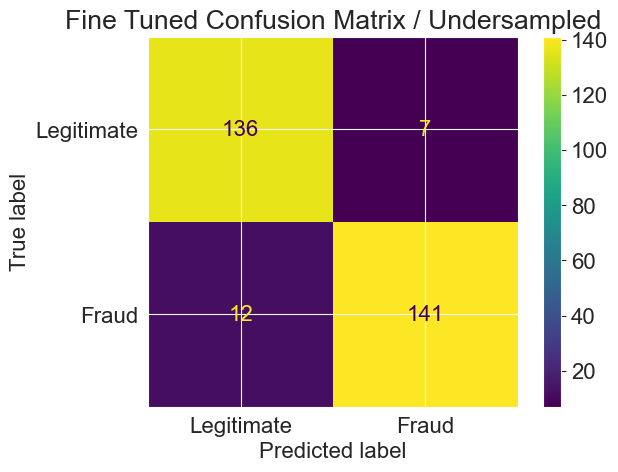

In [23]:
lr_undersampled = LogisticRegression(C=1, penalty='l2')
cmat, pred = RunModel(lr_undersampled, X_undersampled_train, Y_undersampled_train, X_undersampled_test, Y_undersampled_test)
PrintStats(cmat, Y_undersampled_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=class_names)
disp.plot(values_format='d')  # 'd' to display numbers as integers
plt.title('Fine Tuned Confusion Matrix / Undersampled')
plt.show()

In [24]:
accuracy_score(Y_undersampled_test, pred)

0.9358108108108109

In [25]:
print (classification_report(Y_undersampled_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       143
           1       0.95      0.92      0.94       153

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



While overall accuracy has decreased, sensitivity has significantly improved. From the confusion matrix, we can see that the model now correctly identifies a much higher proportion of fraudulent transactions. However, this improvement typically comes at the cost of misclassifying more legitimate transactions as fraudulent.

In [26]:
# Fianl Fine Tiuned Model

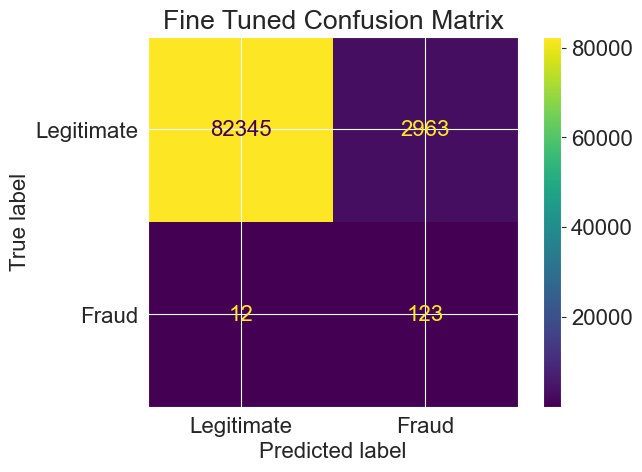

In [27]:
lr = LogisticRegression(C=1, penalty='l2')
cmat, pred = RunModel(lr, X_undersampled_train, Y_undersampled_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=class_names)
disp.plot(values_format='d')  # 'd' to display numbers as integers
plt.title('Fine Tuned Confusion Matrix')
plt.show()

# Final results
The confusion matrix for the Logistic Regression model indicates:

- 82,345 transactions were correctly classified as normal
- 2963 transactions were incorrectly flagged as fraud (Type I error)
- 12 transactions were mislabeled as normal but were actually fraud (Type II error)
- 123 transactions were correctly identified as fraud

In [28]:
accuracy_score(y_test, pred)

0.9651814660065775

In [29]:
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85308
           1       0.04      0.91      0.08       135

    accuracy                           0.97     85443
   macro avg       0.52      0.94      0.53     85443
weighted avg       1.00      0.97      0.98     85443



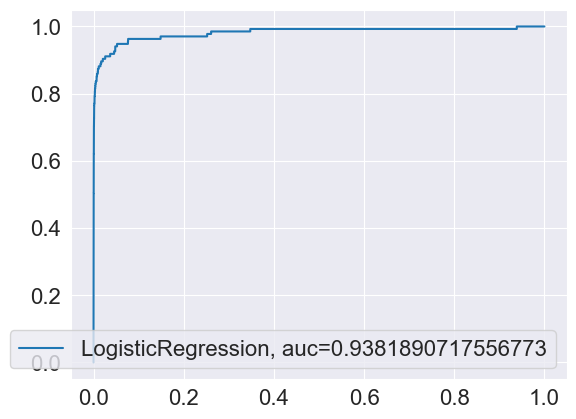

In [30]:
from sklearn import metrics  
clf = LogisticRegression(C=1, penalty='l2')
clf.fit(X_undersampled_train, Y_undersampled_train)
y_pred = clf.predict(X_test)

y_pred_probability = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_probability)
auc = metrics.roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="LogisticRegression, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Summary

By adjusting the model, the correct detection rate for fraudulent transactions increased significantly, jumping from 55% to 91%. On the other hand, the correct identification rate for legitimate transactions dropped slightly, from 99% to 97%.

Ultimately, it is important to strike a balance between these two metrics. In many cases, the cost of missing a fraudulent transaction outweighs the inconvenience of falsely flagging a legitimate one. To further refine the model, techniques such as data preprocessing and feature engineering can be employed to potentially boost performance.

# Model Parameters

In [39]:
print("\nLearned Coefficients:")
print(lr.coef_)

print("\nLearned Intercept:")
print(lr.intercept_)


Learned Coefficients:
[[-0.06903161 -0.4088332  -0.18785614  1.00227142 -0.16918132 -0.07360419
   0.5482526  -0.58590402 -0.2067429  -0.50340101  0.5276586  -0.71843683
  -0.69000077 -0.76861882  0.11804707 -0.28991264 -0.13933811 -0.20988605
  -0.44476081 -0.03986253  0.28903456  0.01398066 -0.61371378  0.21099853
  -0.36389036 -0.15127222 -0.03876914  0.46852015 -0.00223385]]

Learned Intercept:
[-3.2155449]


In [40]:
lr.coef_

array([[-0.06903161, -0.4088332 , -0.18785614,  1.00227142, -0.16918132,
        -0.07360419,  0.5482526 , -0.58590402, -0.2067429 , -0.50340101,
         0.5276586 , -0.71843683, -0.69000077, -0.76861882,  0.11804707,
        -0.28991264, -0.13933811, -0.20988605, -0.44476081, -0.03986253,
         0.28903456,  0.01398066, -0.61371378,  0.21099853, -0.36389036,
        -0.15127222, -0.03876914,  0.46852015, -0.00223385]])

In [35]:
X_undersampled_train.values[1]

array([ 1.83319105e+00,  7.45332779e-01, -1.13300871e+00,  3.89355598e+00,
        8.58163817e-01,  9.10234501e-01, -4.98200069e-01,  3.44703186e-01,
       -6.67939096e-01,  3.98155065e-01,  6.13867739e-01, -2.25614828e-02,
        4.52018065e-01, -2.96920096e+00, -9.64967034e-01,  2.46444980e+00,
        6.71240576e-01,  1.92102109e+00, -1.61692659e+00, -8.55787549e-02,
        3.92894903e-02,  1.81651615e-01,  7.29809106e-02, -1.55298849e-01,
       -1.49891395e-01,  1.27924878e-02,  4.08538192e-02,  2.29031159e-02,
        1.73900000e+01])

In [33]:
Y_undersampled_train

163586    1
238466    1
41943     1
163666    0
255206    0
         ..
6870      1
224345    0
69498     1
154719    1
102899    0
Name: Class, Length: 688, dtype: int64

In [45]:
# Step 1: Compute the linear combination (z)
#z =  np.dot(lr.coef_, X_undersampled_train.values[1])
z = lr.intercept_ + np.dot(lr.coef_, X_undersampled_train.values[1])
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

probability = sigmoid(z)
z, probability

(array([1.3859132]), array([0.79993901]))

In [49]:
X_undersampled_train.values[0]

array([ 9.49240655e-01,  1.33351901e+00, -4.85540201e+00,  1.83500588e+00,
       -1.05324529e+00, -2.56282607e+00, -2.28698563e+00,  2.60906490e-01,
       -8.95365546e-01, -4.54261204e+00,  2.45371038e+00, -4.92519870e+00,
       -1.20041197e+00, -6.42437211e+00,  1.01489749e+00, -3.12942132e+00,
       -5.14703878e+00, -1.81543653e+00,  5.20496923e-01,  4.24608329e-01,
        3.06598170e-01, -8.54626652e-01,  1.01176996e-01, -2.81497410e-01,
        2.44439389e-02, -1.07944112e-01,  6.25288550e-01,  3.15677391e-01,
        6.50000000e+01])

In [50]:
X_undersampled_train.values[1]

array([ 1.83319105e+00,  7.45332779e-01, -1.13300871e+00,  3.89355598e+00,
        8.58163817e-01,  9.10234501e-01, -4.98200069e-01,  3.44703186e-01,
       -6.67939096e-01,  3.98155065e-01,  6.13867739e-01, -2.25614828e-02,
        4.52018065e-01, -2.96920096e+00, -9.64967034e-01,  2.46444980e+00,
        6.71240576e-01,  1.92102109e+00, -1.61692659e+00, -8.55787549e-02,
        3.92894903e-02,  1.81651615e-01,  7.29809106e-02, -1.55298849e-01,
       -1.49891395e-01,  1.27924878e-02,  4.08538192e-02,  2.29031159e-02,
        1.73900000e+01])

In [51]:
X_undersampled_train.values[2]

array([ -2.14051149,   4.10487145,  -8.9968594 ,   4.02839095,
        -5.13135935,  -4.15356845,  -9.36009513,   1.92207488,
        -4.02618037, -13.69131513,   9.09528815, -14.16812088,
        -0.14045539, -17.62063435,   1.48274041, -13.25683309,
       -21.6754835 ,  -7.82346882,   2.99511117,   1.72557762,
         1.85426666,  -0.16553373,  -0.33993898,   0.29631376,
         1.36422533,  -0.51899563,   2.35233347,   1.13062484,
         0.76      ])

In [52]:
X_undersampled_train.values[3]

array([ 2.08159123e+00, -7.74080414e-01, -6.74990508e-01, -3.22870723e-01,
       -8.90004752e-01, -8.01468965e-01, -5.32596118e-01, -2.80944037e-01,
       -3.54142288e-01,  7.99470065e-01, -8.14812023e-01,  6.85306426e-01,
        1.54081885e+00, -3.26998429e-01,  7.29970899e-02, -1.48253805e+00,
       -1.52970277e-01,  7.28147053e-01, -9.31707652e-01, -4.81297649e-01,
       -3.29596858e-01, -3.10602724e-01,  2.68724516e-01,  2.00922706e-02,
       -3.59342800e-01,  5.55034182e-01, -2.53850442e-02, -4.48682471e-02,
        3.52900000e+01])

In [53]:
X_undersampled_train.values[4]

array([ 2.26292850e+00, -1.12503275e+00, -1.00353578e+00, -1.54054672e+00,
       -1.24871400e+00, -1.37195067e+00, -7.49379780e-01, -3.92092331e-01,
       -2.02413001e+00,  1.83195415e+00,  1.50943646e+00,  4.55695564e-01,
        1.24347768e+00, -8.04317087e-02, -6.71814538e-01, -6.36981235e-01,
        3.05873230e-01,  2.35155188e-01, -2.66162999e-01, -3.96292997e-01,
        1.67741819e-01,  9.95494086e-01,  1.18589471e-01,  5.92352231e-01,
        2.14934688e-02,  1.31359426e-02, -9.16496757e-03, -6.39920878e-02,
        1.00000000e+01])

In [54]:
X_undersampled_train.values[5]

array([-0.98380479,  0.93786371,  2.16863206,  1.59299708, -0.63045676,
        0.88820742, -0.07519119,  0.57879802,  0.65137314, -0.35932609,
       -1.22866992,  0.61253985, -0.33162286, -0.71328004, -1.33506809,
       -1.60991986,  1.22499241, -1.04831463,  1.29982267,  0.05630917,
       -0.37427197, -0.47138299, -0.07749574,  0.07296752, -0.07198752,
       -0.40822914,  0.03773442, -0.12005928, 24.95      ])

In [55]:
X_undersampled_train.values[6]

array([ 2.00726151e+00,  1.07343501e-01, -3.27922654e+00,  3.38815551e-01,
        3.20909062e+00,  3.03799289e+00,  1.90754640e-01,  4.63073328e-01,
        9.27006978e-01,  2.01240565e-02,  9.40410768e-01, -2.35920593e+00,
        1.32433419e+00,  2.49377532e+00, -1.85632976e-01, -5.84091783e-01,
        2.37223943e-01, -2.51801877e-01, -7.23436995e-01, -1.91442433e-01,
        3.89660553e-02,  2.96747790e-01, -3.94352044e-02,  6.52840188e-01,
        5.65909629e-01, -4.36614147e-01, -5.11632278e-02, -7.42799360e-02,
        3.60000000e+01])

In [56]:
X_undersampled_train.values[5]

array([-0.98380479,  0.93786371,  2.16863206,  1.59299708, -0.63045676,
        0.88820742, -0.07519119,  0.57879802,  0.65137314, -0.35932609,
       -1.22866992,  0.61253985, -0.33162286, -0.71328004, -1.33506809,
       -1.60991986,  1.22499241, -1.04831463,  1.29982267,  0.05630917,
       -0.37427197, -0.47138299, -0.07749574,  0.07296752, -0.07198752,
       -0.40822914,  0.03773442, -0.12005928, 24.95      ])

In [57]:
X_undersampled_train.values[5]

array([-0.98380479,  0.93786371,  2.16863206,  1.59299708, -0.63045676,
        0.88820742, -0.07519119,  0.57879802,  0.65137314, -0.35932609,
       -1.22866992,  0.61253985, -0.33162286, -0.71328004, -1.33506809,
       -1.60991986,  1.22499241, -1.04831463,  1.29982267,  0.05630917,
       -0.37427197, -0.47138299, -0.07749574,  0.07296752, -0.07198752,
       -0.40822914,  0.03773442, -0.12005928, 24.95      ])

In [58]:
X_undersampled_train.values[5]

array([-0.98380479,  0.93786371,  2.16863206,  1.59299708, -0.63045676,
        0.88820742, -0.07519119,  0.57879802,  0.65137314, -0.35932609,
       -1.22866992,  0.61253985, -0.33162286, -0.71328004, -1.33506809,
       -1.60991986,  1.22499241, -1.04831463,  1.29982267,  0.05630917,
       -0.37427197, -0.47138299, -0.07749574,  0.07296752, -0.07198752,
       -0.40822914,  0.03773442, -0.12005928, 24.95      ])

In [59]:
Y_undersampled_train[0:10]

163586    1
238466    1
41943     1
163666    0
255206    0
73492     0
150814    0
69611     0
76609     1
154587    1
Name: Class, dtype: int64

In [48]:
from openfhe import *
import math

print("--------------------------------- EVAL LOGISTIC FUNCTION ---------------------------------\n")
# plaintextModulus = 65537
# sigma = 3.2
securityLevel = SecurityLevel.HEStd_128_classic

# batchSize = 16
# multDepth = 4
# digitSize = 30
# dcrtBits = 60

parameters = CCParamsCKKSRNS()
#parameters.SetSecurityLevel(SecurityLevel.HEStd_NotSet)
parameters.SetSecurityLevel(securityLevel)
#parameters.SetRingDim(1 << 10)
parameters.SetRingDim(1 << 16)
parameters.SetKeySwitchTechnique(HYBRID)

scaling_mod_size = 30
first_mod_size = 60

parameters.SetScalingModSize(scaling_mod_size)
parameters.SetFirstModSize(first_mod_size)

poly_degree = 16
mult_depth = 6

parameters.SetMultiplicativeDepth(mult_depth)
cc = GenCryptoContext(parameters)
cc.Enable(PKESchemeFeature.PKE)
cc.Enable(PKESchemeFeature.KEYSWITCH)
cc.Enable(PKESchemeFeature.LEVELEDSHE)
cc.Enable(PKESchemeFeature.ADVANCEDSHE)

key_pair = cc.KeyGen()
cc.EvalMultKeyGen(key_pair.secretKey)
cc.EvalSumKeyGen(key_pair.secretKey);

SerializeToFile('cc.dat', cc, BINARY)
SerializeToFile('sk.dat',key_pair.secretKey, BINARY)
SerializeToFile('pk.dat',key_pair.publicKey, BINARY)
cc.SerializeEvalMultKey('mk.dat', BINARY)
cc.SerializeEvalAutomorphismKey('am.dat', BINARY)
#print(len(SerializeEvalSumKeyString(BINARY)))


ModuleNotFoundError: No module named 'openfhe'

In [ ]:
from openfhe import *
import math

cc, success = DeserializeCryptoContext('cc.dat', BINARY)
print(success)
ClearEvalMultKeys()

secretKey, success = DeserializePrivateKey('sk.dat', BINARY)
print(success)
publicKey, success = DeserializePublicKey('pk.dat', BINARY)
print(success)
success = cc.DeserializeEvalMultKey('mk.dat', BINARY)
print(success)

success = cc.DeserializeEvalAutomorphismKey('am.dat', BINARY)
print(success)



# Step 3: Prepare Vectors
vector1 = [complex(a,0) for a in [-0.06903161, -0.4088332 , -0.18785614,  1.00227142, -0.16918132,
        -0.07360419,  0.5482526 , -0.58590402, -0.2067429 , -0.50340101,
         0.5276586 , -0.71843683, -0.69000077, -0.76861882,  0.11804707,
        -0.28991264, -0.13933811, -0.20988605, -0.44476081, -0.03986253,
         0.28903456,  0.01398066, -0.61371378,  0.21099853, -0.36389036,
        -0.15127222, -0.03876914,  0.46852015, -0.00223385]]  # First vector
vector2 = [complex(a,0) for a in [ 1.83319105e+00,  7.45332779e-01, -1.13300871e+00,  3.89355598e+00,
        8.58163817e-01,  9.10234501e-01, -4.98200069e-01,  3.44703186e-01,
       -6.67939096e-01,  3.98155065e-01,  6.13867739e-01, -2.25614828e-02,
        4.52018065e-01, -2.96920096e+00, -9.64967034e-01,  2.46444980e+00,
        6.71240576e-01,  1.92102109e+00, -1.61692659e+00, -8.55787549e-02,
        3.92894903e-02,  1.81651615e-01,  7.29809106e-02, -1.55298849e-01,
       -1.49891395e-01,  1.27924878e-02,  4.08538192e-02,  2.29031159e-02,
        1.73900000e+01]]  # Second vector

vector3 = [complex(a,0) for a in [-3.2155449]]  # Second vector

# Step 4: Encrypt Vectors
plaintext1 = cc.MakeCKKSPackedPlaintext(vector1)
plaintext2 = cc.MakeCKKSPackedPlaintext(vector2)
plaintext3 = cc.MakeCKKSPackedPlaintext(vector3)

ciphertext1 = cc.Encrypt(publicKey, plaintext1)
ciphertext2 = cc.Encrypt(publicKey, plaintext2)
ciphertext3 = cc.Encrypt(publicKey, plaintext3)

# # Step 5: Homomorphic Dot Product
encrypted_dot_product = cc.EvalInnerProduct(ciphertext1, ciphertext2, len(vector1))
encrypted_dot_product = cc.EvalAdd(encrypted_dot_product, ciphertext3)

# # Step 6: Decrypt the Result
decrypted_result = cc.Decrypt(secretKey, encrypted_dot_product)
decrypted_result.SetLength(1)

# # Step 7: Output the Result
print(f"Vector 1: {vector1}")
print(f"Vector 2: {vector2}")
print(f"Decrypted Dot Product: {decrypted_result}")



In [ ]:
from openfhe import *
import math

cc, success = DeserializeCryptoContext('cc.dat', BINARY)
print(success)
ClearEvalMultKeys()

secretKey, success = DeserializePrivateKey('sk.dat', BINARY)
print(success)
publicKey, success = DeserializePublicKey('pk.dat', BINARY)
print(success)
success = cc.DeserializeEvalMultKey('mk.dat', BINARY)
print(success)

success = cc.DeserializeEvalAutomorphismKey('am.dat', BINARY)
print(success)



# Step 3: Prepare Vectors
vector1 = [complex(a,0) for a in [-0.06903161, -0.4088332 , -0.18785614,  1.00227142, -0.16918132,
        -0.07360419,  0.5482526 , -0.58590402, -0.2067429 , -0.50340101,
         0.5276586 , -0.71843683, -0.69000077, -0.76861882,  0.11804707,
        -0.28991264, -0.13933811, -0.20988605, -0.44476081, -0.03986253,
         0.28903456,  0.01398066, -0.61371378,  0.21099853, -0.36389036,
        -0.15127222, -0.03876914,  0.46852015, -0.00223385]]  # First vector
vector2 = [complex(a,0) for a in [ 1.83319105e+00,  7.45332779e-01, -1.13300871e+00,  3.89355598e+00,
        8.58163817e-01,  9.10234501e-01, -4.98200069e-01,  3.44703186e-01,
       -6.67939096e-01,  3.98155065e-01,  6.13867739e-01, -2.25614828e-02,
        4.52018065e-01, -2.96920096e+00, -9.64967034e-01,  2.46444980e+00,
        6.71240576e-01,  1.92102109e+00, -1.61692659e+00, -8.55787549e-02,
        3.92894903e-02,  1.81651615e-01,  7.29809106e-02, -1.55298849e-01,
       -1.49891395e-01,  1.27924878e-02,  4.08538192e-02,  2.29031159e-02,
        1.73900000e+01]]  # Second vector

vector3 = [complex(a,0) for a in [-3.2155449]]  # Second vector

# Step 4: Encrypt Vectors
plaintext1 = cc.MakeCKKSPackedPlaintext(vector1)
plaintext2 = cc.MakeCKKSPackedPlaintext(vector2)
plaintext3 = cc.MakeCKKSPackedPlaintext(vector3)

ciphertext1 = cc.Encrypt(publicKey, plaintext1)
ciphertext2 = cc.Encrypt(publicKey, plaintext2)
ciphertext3 = cc.Encrypt(publicKey, plaintext3)

# # Step 5: Homomorphic Dot Product
encrypted_dot_product = cc.EvalInnerProduct(ciphertext1, ciphertext2, len(vector1))
encrypted_dot_product = cc.EvalAdd(encrypted_dot_product, ciphertext3)

# # Step 6: Decrypt the Result
decrypted_result = cc.Decrypt(secretKey, encrypted_dot_product)
decrypted_result.SetLength(1)

# # Step 7: Output the Result
print(f"Vector 1: {vector1}")
print(f"Vector 2: {vector2}")
print(f"Decrypted Dot Product: {decrypted_result}")

